# NHL MVP Analysis

In this project we try to use machine learning to predict winners of the Hart, Ted Lindsay, Norris, Vezina, and maybe Calder trophy. I expect Calder and Vezina are going to be very easy as there's typically only 2-3 people competing in any given year; the in-game statistics are even more heavily unbalanced in favor of the top players than for other awards.  

Hockey statistics will come from Evolving Hockey and Hockey-Reference. My general plan is to do some basic data analysis to pretend I'm doing data science, and then throw an ensemble from sklearn at it. 
In any given year, I'll take vote receiving players, and we will try to predict their vote share in the final result. 


Some preliminary comments about the data:

1) Goalies have different statistics than non goalies. I will try two approaches to deal with this. In one approach, I will simply set the non-relevant stats for any given player to zero. Hopefully the models will be able to figure out that for a Center, goalie_wins has zero correlation with their vote share. In the second approach, we will train two separate models: one for goalies, and one for non-goalies. 

2) The vote share is a very skewed data set. For example, below are shown the NHL voting data for the Hart trophy in the 17-18 season. Vote share approximately follows $e^{-x/\xi}$. By observation, in any given year there are usually two at most "serious contenders" for Hart, and often the winner has on the order of 50 to 100% more votes than second place. This may make life challenging as a small difference in statistics between the top 2 or 3 players in any given year can lead to a dramatic difference in vote share. This is an inherent feature of the data: players vote share is not computed in a vacuum, but is heavily influenced by what other players accomplished in a given year. That likely requires much more sophisticated analysis. 

In [3]:
# imports
import numpy as np
import pandas as pd
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', 500)

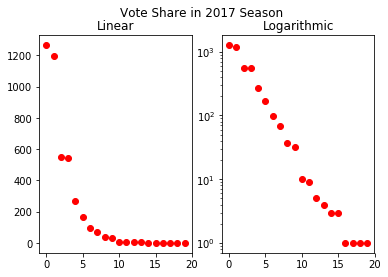

In [4]:
sample_vote = pd.read_csv("2017mvp.csv")
sample_vote.columns.values
vote_share = sample_vote["Votes"]

fig = plt.figure()

ax = plt.subplot(121)
ax.plot(vote_share,'ro')
ax.set_title("Linear")
plt.suptitle("Vote Share in 2017 Season")

ax=plt.subplot(122)
ax.semilogy(vote_share,'ro')
ax.set_title("Logarithmic")
plt.show()

In [137]:


# import full data
full_data= pd.read_csv("hockey-data-hart.csv")    
full_data=full_data.dropna(axis=0,subset=['pct_of_vote'])
full_data=full_data.drop(['first','second','third','fourth','fifth'],axis=1)

# let's also drop goalies who are missing save pct, and field players who are missing plus_minus
full_data = full_data.loc[~((full_data.pos=="G") & full_data.save_pct.isna())]
full_data = full_data.loc[~((full_data.pos!="G") & full_data.plus_minus.isna())]

# remaining na's should be due to mismatched position with stats. set them to zero
full_data = full_data.fillna(0)




# for non goalies (goalies), let's replace all goalie (non goalie) stats by zero rather than NaN



# Create a new feature p_simp, containing the titles of passenger names
def pos_combine(name):
    title_search = re.search('(^[A-Z]{1,2})', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

full_data["pos_simp"] = full_data["pos"].apply(pos_combine)

# for later: one hot encode simple position
full_data=pd.get_dummies(full_data,columns=['pos_simp'])





# # set up data for goalies
# goalies = full_data[full_data['pos_simp']=='G']
# goalie_feature_keep = ['player','Year','age','pct_of_vote','wins_goalie',
#                        'losses_goalie','ties_goalie','goals_against_avg','save_pct','ps']

# goalies=goalies[goalie_feature_keep]
# goalies = goalies.dropna(axis=0)

# # set up data for non goalies
# non_goalies = full_data[full_data['pos_simp']!= 'G']
# non_g_feature_keep = ['Year','player','pos_simp','pct_of_vote','goals','assists','plus_minus','ops','dps']
# non_goalies = non_goalies[non_g_feature_keep]
# # throw away players without a plus minus
# non_goalies=non_goalies.dropna(axis=0,subset=["plus_minus"])



# stats_train, stats_test = train_test_split(full_data)
# full_data.pos.unique()
    
full_data.sample(10)


,Year,player,age,team_id,pos,votes,pct_of_vote,goals,assists,points,plus_minus,wins_goalie,losses_goalie,ties_goalie,goals_against_avg,save_pct,ops,dps,gps,ps,pos_simp_C,pos_simp_D,pos_simp_G,pos_simp_LW,pos_simp_RW
236,1964,Kenny Wharram,30,Chicago Black Hawks,RW,3.0,0.93,39,32,71,25.0,0.0,0.0,0.0,0.00,0.00,7.7,1.2,0.0,9.0,0,0,0,0,1
579,1992,Dale Hunter,31,Washington Capitals,C,1.0,0.29,28,50,78,-2.0,0.0,0.0,0.0,0.00,0.00,5.1,0.8,0.0,6.0,1,0,0,0,0
287,1971,Bobby Orr,22,Boston Bruins,D,151.0,39.95,37,102,139,124.0,0.0,0.0,0.0,0.00,0.00,13.5,9.3,0.0,22.8,0,1,0,0,0
309,1972,Vic Hadfield,31,New York Rangers,LW,18.0,4.74,50,56,106,60.0,0.0,0.0,0.0,0.00,0.00,10.5,2.6,0.0,13.1,0,0,0,1,0
639,1997,Teemu Selanne,26,Mighty Ducks of Anaheim,RW,70.0,12.96,51,58,109,28.0,0.0,0.0,0.0,0.00,0.00,11.8,1.9,0.0,13.7,0,0,0,0,1
881,2009,Sidney Crosby,21,Pittsburgh Penguins,C,103.0,7.74,33,70,103,3.0,0.0,0.0,0.0,0.00,0.00,9.4,1.7,0.0,11.1,1,0,0,0,0
892,2009,Nicklas Lidstrom,38,Detroit Red Wings,D,7.0,0.53,16,43,59,31.0,0.0,0.0,0.0,0.00,0.00,5.5,5.7,0.0,11.2,0,1,0,0,0
706,2000,Martin Brodeur,27,New Jersey Devils,G,6.0,1.03,1,4,5,0.0,43.0,20.0,8.0,2.24,0.91,0.0,0.0,12.1,12.1,0,0,1,0,0
623,1996,Peter Forsberg,22,Colorado Avalanche,C,8.0,1.48,30,86,116,26.0,0.0,0.0,0.0,0.00,0.00,9.5,1.5,0.0,11.0,1,0,0,0,0
984,2013,Alex Ovechkin,27,Washington Capitals,RW,1090.0,60.89,32,24,56,2.0,0.0,0.0,0.0,0.00,0.00,7.0,1.0,0.0,8.0,0,0,0,0,1


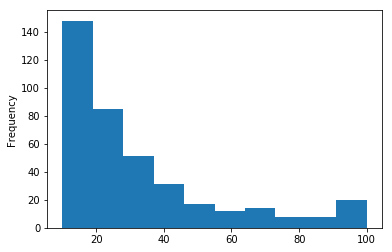

In [4]:
# (full_data['pos'].value_counts()/len(full_data)).plot.bar()

full_data[full_data['pct_of_vote']>10]['pct_of_vote'].plot.hist()

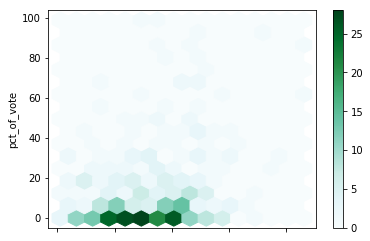

In [5]:
fd=
fd[fd['goals']>0].sample(400).plot.hexbin(x='goals',y='pct_of_vote',gridsize=15)

/Users/danielben-zion/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


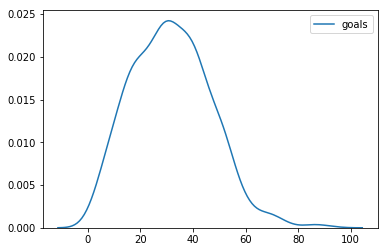

In [6]:
sns.kdeplot(fd[fd['goals']>0]['goals'])

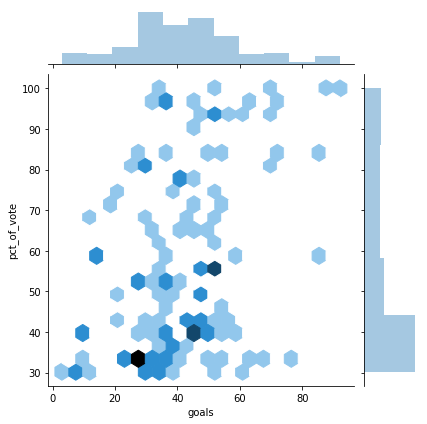

In [7]:
sns.jointplot(x='goals',y='pct_of_vote',data = fd[(fd['goals']>0) & (fd['pct_of_vote']>30)], kind='hex', gridsize=20)

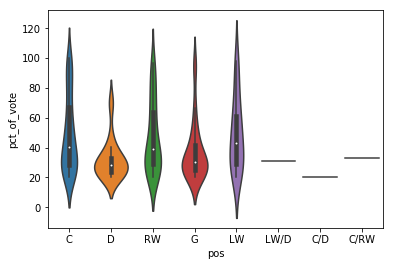

In [8]:
sns.violinplot(x='pos',y='pct_of_vote',data=fd[fd['pct_of_vote']>20])

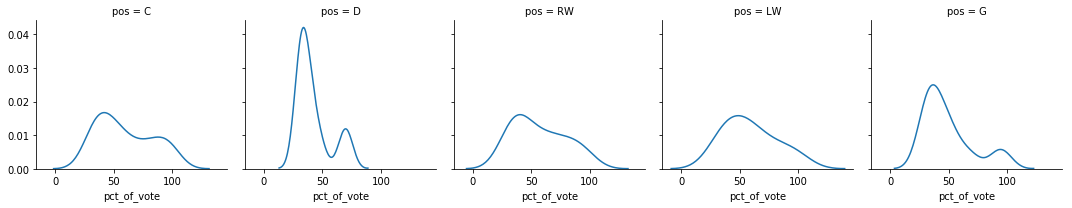

In [26]:
full_data['pos'].unique()
df = full_data[full_data['pos'].isin(['G', 'C','D','RW','LW'])]
g = sns.FacetGrid(df[df['pct_of_vote']>30], col="pos")
g.map(sns.kdeplot,"pct_of_vote")


In [57]:
full_data.columns


Index([u'Year', u'player', u'age', u'team_id', u'pos', u'votes',
       u'pct_of_vote', u'first', u'second', u'third', u'fourth', u'fifth',
       u'goals', u'assists', u'points', u'plus_minus', u'wins_goalie',
       u'losses_goalie', u'ties_goalie', u'goals_against_avg', u'save_pct',
       u'ops', u'dps', u'gps', u'ps'],
      dtype='object')

/Users/danielben-zion/anaconda2/lib/python2.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


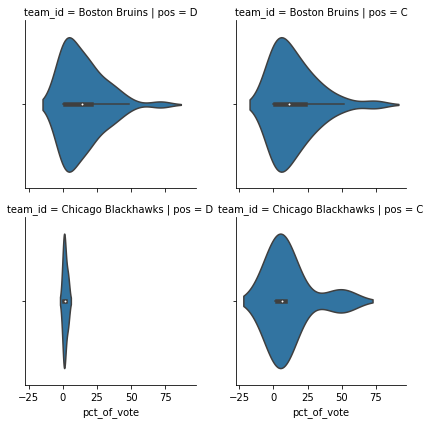

In [56]:
df = full_data[full_data['pos'].isin(['C','D'])]

df = df[df['team_id'].isin(['Chicago Blackhawks','Boston Bruins'])]
df
# df = df[df['pct_of_vote']>1]

g = sns.FacetGrid(df, row="team_id", col="pos")
g.map(sns.violinplot,'pct_of_vote')

124.0


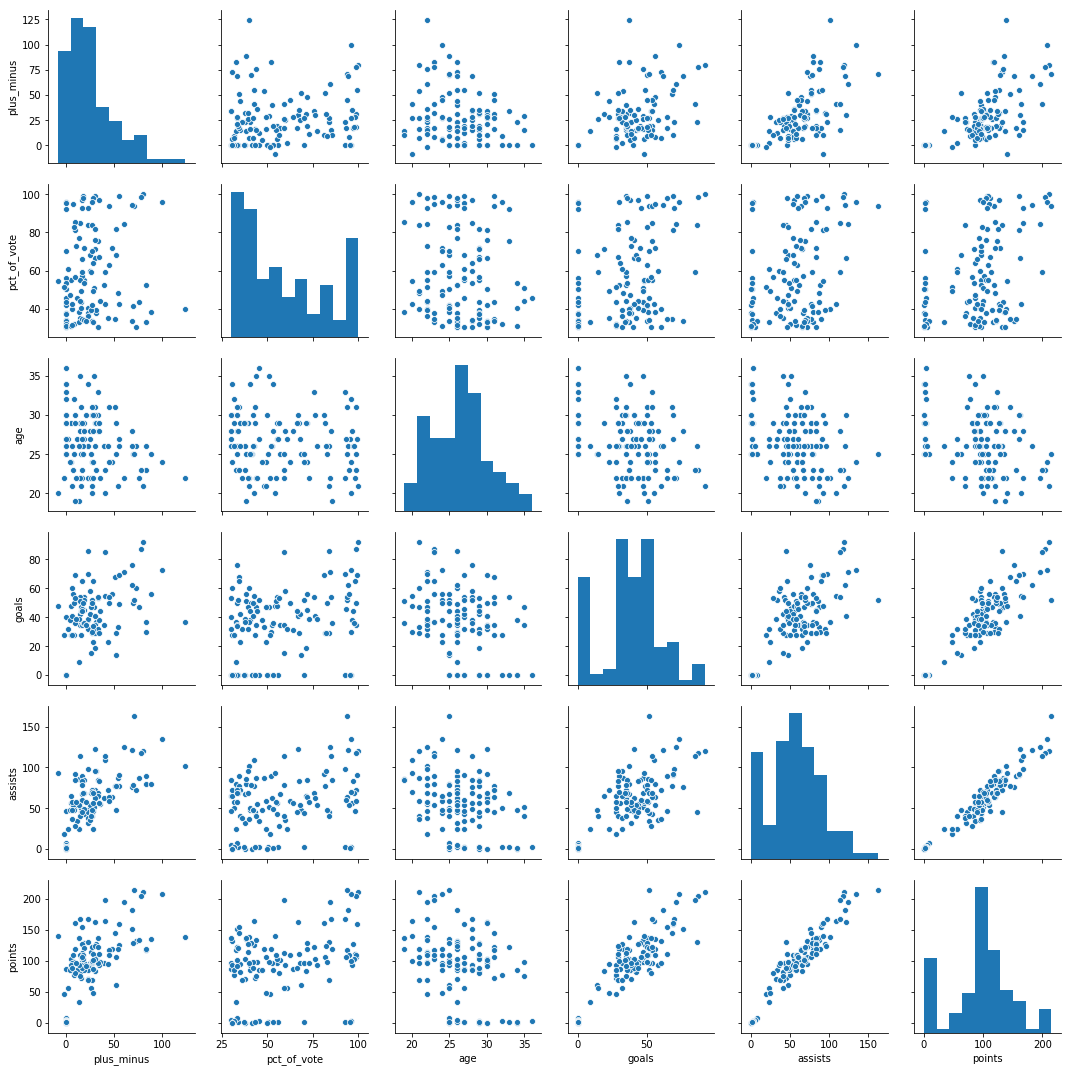

In [72]:

df = full_data[full_data['plus_minus'].notna()]
df = df[df['pct_of_vote']>30]
print(df.plus_minus.max())
sns.pairplot(df[['plus_minus','pct_of_vote','age','goals', 'assists', 'points']])


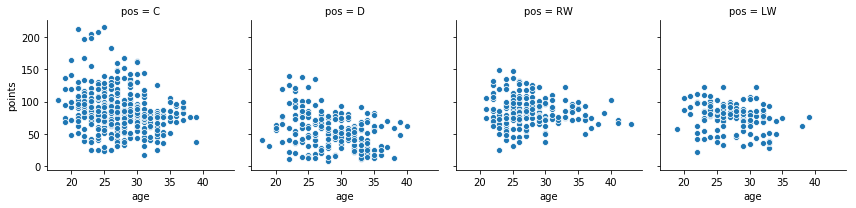

In [105]:
non_goalies = full_data[full_data["goals"]>0]
ng = non_goalies[non_goalies['pos'].isin(["C","RW","LW","D"])]
# sns.lmplot(x='age',y='points',hue='pos', data = non_goalies[non_goalies['pos'].isin(["C",'RW','LW','D'])], 
#           fit_reg = False)
g = sns.FacetGrid(ng,col="pos")
g.map(sns.scatterplot, 'age','points')

Index([u'Year', u'player', u'age', u'team_id', u'pos', u'votes',
       u'pct_of_vote', u'goals', u'assists', u'points', u'ops', u'dps', u'gps',
       u'ps'],
      dtype='object')


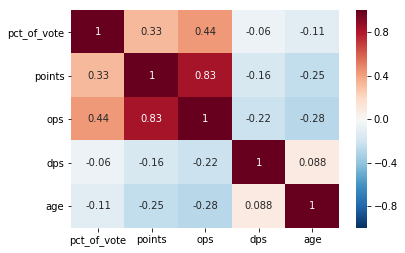

In [131]:
non_goalies = full_data[full_data["goals"]>0]
ng = non_goalies[non_goalies['pos'].isin(["C","RW","LW","D"])]
ng=ng.dropna(axis=1,how='any')
print(ng.columns.unique())
features= ['pct_of_vote','points','ops','dps','age']
ng = ng[features]
f = ng.corr()

sns.heatmap(f,annot=True,cmap="RdBu_r",vmin=-1,vmax=1)
